<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

---

<h2 style="text-align: center;"><b>Задание</b></h2>

Добейтесь как можно лучшего качества в соревновании!

[Journey to Springfield](https://www.kaggle.com/c/simpsons3)

`sklearn` - не используется, все необходимое реализовано с помощью `torch`, `numpy`

In [1]:
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

from torchvision import transforms

from PIL import Image
from tqdm import tqdm, tqdm_notebook

from matplotlib import pyplot as plt

# Работа с путями в системе
from pathlib import Path

import pandas as pd
import datetime


%matplotlib inline

# torch.save - не любит сохранять модели из ноутбуков
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

### Настройки

In [2]:
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224

if IN_COLAB:
    # Настройки, при запуске на colab    
    from google.colab import drive
    drive.mount('/content/gdrive/')

    TRAIN_DIR = Path(r'/content/gdrive/My Drive/data/train/')
    TEST_DIR = Path(r'/content/gdrive/My Drive/data/test/')
    SAVE_DIR = Path(r'/content/gdrive/My Drive/data/')
else:
    # Настройки, при запуске на локальном комьютере
    TRAIN_DIR = Path(r'../data/Simpsons/train/')
    TEST_DIR = Path(r'../data/Simpsons/test/')
    SAVE_DIR = Path(r'../data/Simpsons/')
    
if torch.cuda.is_available():
    # работаем на GPU
    DEVICE = torch.device("cuda")
else:
    # работаем на CPU
    DEVICE = torch.device("cpu")

Отказался от `sklearn.preprocessing.LabelEncoder`, использую `np.unique`.  
Разбитие на тестовую и валидационную выборку реализовано через `torch.utils.data.random_split`

In [3]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    
    rnd_transform - Применять ли случайные преобразования к изображениям
    preload - храним изображения в пямяти, примерно 4Гб
    """
    def __init__(self, file_dir, rnd_transform=False, preload=False):
        super().__init__()
        
        # список файлов для загрузки
        self.file_path = sorted(Path(file_dir).rglob('*.jpg'))
        # Список имен и меток
        self.labels_ = np.unique([path.parent.name for path in self.file_path], 
                                 return_inverse = True)

        # Добавлять ли случайные аугментации изображения
        if rnd_transform:
            self.rnd_transform = transforms.RandomChoice([
                transforms.RandomHorizontalFlip(p=0.66),
                transforms.RandomVerticalFlip(p=0.66),
                transforms.RandomRotation(180),
            ])
        else:
            self.rnd_transform = lambda x: x

        # Обязательные преобразование
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])

        # Хранилище изображений
        self.images = None
        if preload:
            self.images = [self.image_from_file(name) for name in self.file_path]
                      
    def __len__(self):
        # Количество файлов в датасете
        return len(self.file_path)

    def image_from_file(self, name):
        # Загружаем изображение из файла
        x = Image.open(name)
        x.load()
        # Ресайзим
        x = x.resize((RESCALE_SIZE, RESCALE_SIZE))
        return x

    def image(self, idx):
        # Получаем изображение по индексу
        if self.images is not None:
            return self.images[idx] 
        else:
            return self.image_from_file(self.file_path[idx])

    @property
    def labels(self):
        # Текстовые метки датасета
        return self.labels_[0].copy()

    def random_split(self, percent):
        # Разбивка датасета на тренировочный и валидационный
        # percent - доля валидационного датасета

        percent = min(max(0, percent), 1)
        val_len = round(len(self) * percent)

        return random_split(self, [len(self) - val_len, val_len])
      
    def __getitem__(self, idx):
        # Загружаем изображение
        x = self.image(idx)

        # Случайные преобразования изображения
        x = self.rnd_transform(x)

        # Нормализуем
        x = np.array(x, dtype='float32') / 255

        # Дополнительные трансформации
        x = self.transform(x)
        
        return x, self.labels_[1][idx]


In [4]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [5]:
def graph(line1, line2, loss=True):
    # Графики потерь, точности
    if loss:
        text = ("train_loss", "val_loss", "epochs", "loss")
    else:
        text = ("train_acc", "val_acc", "epochs", "acc")
        
    plt.figure(figsize=(12, 7))
    plt.plot(line1, label=text[0])
    plt.plot(line2, label=text[1])
    plt.legend(loc='best')
    plt.xlabel(text[2])
    plt.ylabel(text[3])
    plt.show()

In [6]:
def fit_epoch(model, train_loader, criterion, optimizer):
    # Обучение 1 эпоха
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    
    return train_loss, train_acc

In [7]:
def eval_epoch(model, val_loader, criterion):
    # Валидация
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    
    return val_loss, val_acc

In [8]:
def train(train_dataset, val_dataset, model, epochs, batch_size, auto_save = False):
    # Обучение модели 
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    # Добавляем возможность обучать модель, без валидации
    if val_dataset is not None:
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    # Точность модели на предудущим шаге
    train_acc = 0
    # Лучшая точность модели
    max_acc = -1
    
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm_notebook(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss().to(DEVICE)

        for epoch in range(epochs):
            if auto_save and max_acc < train_acc:
                # Сохраняем лучшую модель
                torch.save(model, SAVE_DIR.joinpath(f"model.pth"))
                max_acc = train_acc

            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            if val_dataset is not None:
                val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            else:
                val_loss, val_acc = -1, -1
                
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, 
                                           t_loss=train_loss,
                                           v_loss=val_loss, 
                                           t_acc=train_acc, 
                                           v_acc=val_acc))
        if auto_save and train_acc < max_acc:
            print("Загружаем модель с train_acc = ", max_acc)
            model = torch.load(SAVE_DIR.joinpath("model.pth"))
            model.eval()
            
    return history

In [9]:
def predict(model, test_loader):
    # Предсказания по тестовой выборке
    with torch.no_grad():
        logits = []
    
        for inputs, _ in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs


In [10]:
def save_predict(model, labels):
    # Сохранение результатов по тестовой выборке
    # Тестовый датасет
    test_dataset = SimpsonsDataset(TEST_DIR)
    test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)

    # Предсказания
    probs = predict(model, test_loader)
    preds = list(labels[i] for i in np.argmax(probs, axis=1))
    
    # Имена файлоа
    test_filenames = [path.name for path in test_dataset.file_path]
    
    # Датафрейм с ответами 
    my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})

    # "Уникальное" имя файла
    today = datetime.datetime.today().strftime("%Y%m%d_%H%M%S")
    today = f"cnn_{today}.csv"

    # Сохраняем в файл
    my_submit.to_csv( SAVE_DIR.joinpath(today), index=False )
    print("Файл сохранен:", today)


n_classes: 42

dataset_x: 15700 (0.75)
dataset_y:  5233 (0.25)


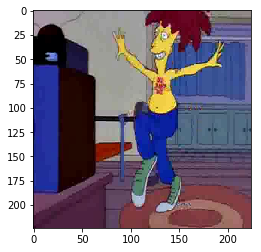

In [11]:
# Полный тренировочный датасет 
full_dataset = SimpsonsDataset(TRAIN_DIR, rnd_transform=False, preload=True)
# Разбиваем на 2
dataset_x, dataset_y = full_dataset.random_split(0.25)
# Количество классов
n_classes = len(full_dataset.labels)

print(f"n_classes: {n_classes}\n")
print("dataset_x:", 
      f"{len(dataset_x):>5}", 
      f"({len(dataset_x) / len(full_dataset):.2})")
print("dataset_y:", 
      f"{len(dataset_y):>5}", 
      f"({len(dataset_y) / len(full_dataset):.2})")

imshow(dataset_x[0][0])

In [12]:
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.flattern = 128 * 24 * 24
        """
        Использую 3 блока с одинаковой структурой:
        [Conv - Активация - Нормализация ] * 2 в каждом слое количество выходных каналов
        совпадает. На предыдущих заданиях убедился, что такая структура дает макс.эффект.
        В принципе, интернет только подтверждает это
        """
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(32),
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(128),
        )
        """
        Между тремя основными блоками использую пулинг и дропаут
        """
        self.PollDrop = nn.Sequential(
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=0.2)
        )
        
        """
        Завершает модель два полносвязанных слоя, первый с большим количеством выходных
        нейронов и большим дропаутом. До этого подобную схему, не применял. Подсмотренно
        на просторах интернета, на удивление - оказалось рабочей. Сети с меньшим количеством
        выходных нейронов (уменьшал до 128 с шагом 128) и меньшим размером дропаута 
        (до 0) - переобучались заметно быстрее и не давали нужной точности
        """
        self.full1 = nn.Sequential(
            nn.Linear(self.flattern, 1024),
            nn.ReLU(),
            torch.nn.BatchNorm1d(1024),
            nn.Dropout(p=0.5),
        )
        
        self.out = nn.Linear(1024, n_classes)

    def forward(self, x, calc_flattern=False):
        # 1 блок
        x = self.conv1(x)
        x = self.PollDrop(x)
        # 2 блок
        x = self.conv2(x)
        x = self.PollDrop(x)
        # 3 блок
        x = self.conv3(x)
        x = self.PollDrop(x)

        if calc_flattern:
            # При изменении слоев, можно передать 1 параметр и посмотреть, какая чиселка нужна
            print(x.shape)
            return None
        # Конвертируем каждый батч в 1 массив
        x = x.view(x.size(0), -1)

        # Два полносвязанных слоя
        x = self.full1(x)
        logits = self.out(x)
        return logits


Запускаем модель по тренировочной, валидационной выборке. По графикам лосса и точности, определеяем когда начинается переобучение (при проверке задания можно пропустить и сразу перейти к последней ячейке ноутбука и тренировать модель уже на полной выборке).   
Для данной модели, получилось следующее:  
__lr__ - стандартный, увеличение или уменьшение приводит к увеличению количество эпох для обучения или падению точности.  
__epoch__ - 10, т.к. есть восстановление модели с наиболее удачным показателем обучения берем максимум  
__batch_size__ - 64, меньше хуже, возможно связано с громадным дропаутом между *Linear* слоями  

In [13]:
simple_cnn = SimpleCnn(n_classes).to(DEVICE)

history = train(dataset_x, 
                dataset_y, 
                model=simple_cnn, 
                epochs=15, 
                batch_size=64)

loss 2.016906853876296

Epoch 001 train_loss: 2.0169     val_loss 1.3274 train_acc 0.4806 val_acc 0.6394
loss 1.0134523204633386

Epoch 002 train_loss: 1.0135     val_loss 0.9577 train_acc 0.7161 val_acc 0.7460
loss 0.3986373924146033

Epoch 003 train_loss: 0.3986     val_loss 0.9460 train_acc 0.8859 val_acc 0.7724
loss 0.14681222394773155

Epoch 004 train_loss: 0.1468     val_loss 1.1364 train_acc 0.9542 val_acc 0.7722
loss 0.14068793125972626

Epoch 005 train_loss: 0.1407     val_loss 1.2413 train_acc 0.9567 val_acc 0.7653
loss 0.10822761508120093

Epoch 006 train_loss: 0.1082     val_loss 1.4194 train_acc 0.9669 val_acc 0.7548
loss 0.08201603078348621

Epoch 007 train_loss: 0.0820     val_loss 1.3790 train_acc 0.9774 val_acc 0.7650
loss 0.07316663133108003

Epoch 008 train_loss: 0.0732     val_loss 1.5312 train_acc 0.9783 val_acc 0.7726
loss 0.07228240415548823

Epoch 009 train_loss: 0.0723     val_loss 1.4622 train_acc 0.9782 val_acc 0.7506
loss 0.07078155647512455

Epoch 010 train

Анализировал только график лоса и точности. Матрица ошибок покажет, какие два класса сеть путает, но я не знаю как это исправить (какие фильтры или ансамбли нужно применять). По-этому сконцентрировался на общих показателях и использовал метод перебора, в купе с гуглом.  
После ряда тестов, остановился на текущей схеме и дополнил ее сохранением восстановлением весов при обучении.

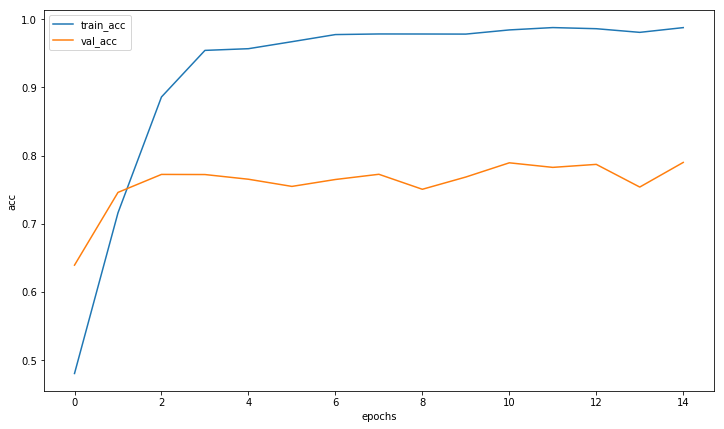

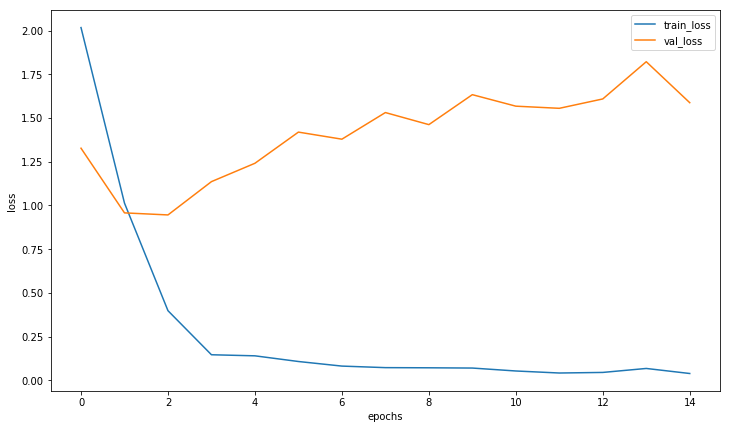

In [14]:
# Графики лоса, точности
loss, acc, val_loss, val_acc = zip(*history)
graph(acc, val_acc, False)
graph(loss, val_loss)

Финальное обучение. Используем полный тренировочный датасет, колическтво эпох и размер батча, определеные на предудыщим шаге, включаем автоматическое сохранение модели при достижении нового максимума точности по тренировочной выборке

In [15]:
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
val_dataset = None

_ = train(full_dataset, 
          val_dataset, 
          model=simple_cnn, 
          epochs=10, 
          batch_size=64, 
          auto_save=True)
    
    
save_predict(simple_cnn, full_dataset.labels)

loss 1.8124329879383791

Epoch 001 train_loss: 1.8124     val_loss -1.0000 train_acc 0.5283 val_acc -1.0000
loss 0.8744382237884641

Epoch 002 train_loss: 0.8744     val_loss -1.0000 train_acc 0.7625 val_acc -1.0000
loss 0.40341688964425343

Epoch 003 train_loss: 0.4034     val_loss -1.0000 train_acc 0.8922 val_acc -1.0000
loss 0.15202149752076696

Epoch 004 train_loss: 0.1520     val_loss -1.0000 train_acc 0.9615 val_acc -1.0000
loss 0.06396587198066374

Epoch 005 train_loss: 0.0640     val_loss -1.0000 train_acc 0.9847 val_acc -1.0000
loss 0.06243110003751733

Epoch 006 train_loss: 0.0624     val_loss -1.0000 train_acc 0.9845 val_acc -1.0000
loss 0.029936145199865413

Epoch 007 train_loss: 0.0299     val_loss -1.0000 train_acc 0.9936 val_acc -1.0000
loss 0.0206113936982756

Epoch 008 train_loss: 0.0206     val_loss -1.0000 train_acc 0.9961 val_acc -1.0000
loss 0.07450466176820361

Epoch 009 train_loss: 0.0745     val_loss -1.0000 train_acc 0.9783 val_acc -1.0000
loss 0.10118189812566